## Run UDFs on Merlin live streams

If you want to use this with the simulated data source, run a simple Merlin simulator in the background that replays an MIB dataset:

`libertem-live-mib-sim ~/Data/default.hdr --cached=MEM --wait-trigger`

The `--wait-trigger` option is important for this notebook to function correctly since that allows to drain the data socket before an acquisition like it is necessary for a real-world Merlin detector.

On Linux, `MEMFD` is also supported as a cache. Use `NONE` to deactivate the cache.

* Make sure to adjust the `SCAN_SIZE` below to match the scan of the data source!
* This notebook requires the `bqplot` extra of LiberTEM: `pip install libertem[bqplot]`

In [1]:
%matplotlib nbagg
%load_ext autoreload

In [2]:
# set this to the host/port where the merlin data server is listening:
MERLIN_DATA_SOCKET = ('127.0.0.1', 6342)
MERLIN_CONTROL_SOCKET = ('127.0.0.1', 6341)
NAV_SHAPE = (256, 256)
SIG_SHAPE = (512, 512)

In [3]:
import logging
import time
import concurrent.futures


import numpy as np
import ipywidgets
from contextlib import contextmanager

In [4]:
logging.basicConfig(level=logging.INFO)

In [5]:
# Sum all detector frames, result is a map of the detector
from libertem.udf.sum import SumUDF
# Sum up each detector frame, result is a bright field STEM image of the scan area
from libertem.udf.sumsigudf import SumSigUDF

# ImageGL-accelerated plot for fast live display
from libertem.viz.bqp import BQLive2DPlot
# Alternatively a version that uses the slower, but more mature Matplotlib
from libertem.viz.mpl import MPLLive2DPlot

INFO:empyre:Imported EMPyRe V-0.3.1 GIT-e85a58daa6bbd861c3aa1fe26e1d609f376f1adc


In [6]:
from libertem_live.api import LiveContext
from libertem_live.detectors.merlin import MerlinControl
from libertem_live.udf.monitor import SignalMonitorUDF

In [7]:
ctx = LiveContext()

### Camera setup routines

Different from offline processing, the shape, type and content of a dataset is not predetermined in live processing.
Instead, the data source has to be configured to supply the desired data. The `set_nav()` function at the bottom accepts an acquisition object as a parameter to make it easier to configure a matching scan resolution.

In [8]:
def merlin_setup(c: MerlinControl, dwell_time=1e-3, depth=6, save_path=None):
    print("Setting Merlin acquisition parameters")
    # Here go commands to control the camera and the rest of the setup
    # to perform an acquisition.

    # The Merlin simulator currently accepts all kinds of commands
    # and doesn't respond like a real Merlin detector.
    c.set('CONTINUOUSRW', 1)
    c.set('ACQUISITIONTIME' , dwell_time * 1e3)  # Time in miliseconds
    c.set('COUNTERDEPTH', depth)
    
    # Soft trigger for testing
    # For a real STEM acquisition the trigger setup has to be adapted for the given instrument.
    # See the MerlinEM User Manual for more details on trigger setup
    c.set('TRIGGERSTART', 5)
    
    c.set('RUNHEADLESS', 1)
    c.set('FILEFORMAT', 2)  # 0 binary, 2 raw binary

    if save_path is not None:
        c.set('IMAGESPERFILE', 256)
        c.set('FILEENABLE', 1)
        c.set('USETIMESTAMPING', 0)  # raw format with timestamping is buggy, we need to do it ourselves
        c.set('FILEFORMAT', 2)  # raw format, less overhead?
        c.set('FILEDIRECTORY', save_path)
    else:
        c.set('FILEENABLE', 0)

    print("Finished Merlin setup.")
        
def microscope_setup(dwell_time=1e-3):
    # Here go instructions to set dwell time and
    # other scan parameters
    # microscope.set_dwell_time(dwell_time)
    pass

def arm(c: MerlinControl):
    print("Arming Merlin...")
    c.cmd('STARTACQUISITION')
    print("Merlin ready for trigger.")
    

def set_nav(c: MerlinControl, aq):
    height, width = aq.shape.nav
    print("Setting resolution...")
    c.set('NUMFRAMESTOACQUIRE', height * width)
    # Only one trigger for the whole scan with SOFTTRIGGER
    # This has to be adapted to the real trigger setup.
    # Set to `width` for line trigger and to `1` for pixel trigger.
    c.set('NUMFRAMESPERTRIGGER', height * width)
    
    # microscope.configure_scan(shape=aq.shape.nav)

### Trigger function

A LiberTEM Live acquisition object should include a trigger callback function so that LiberTEM Live can set off the acquisition as soon as it has connected to the camera and is ready to receive data. The trigger function receives the acquisition object as a parameter. Here we also create an `AcquisitionState` object that allows to collect the result of a trigger function, and a thread pool to run a blocking function in the background.

In [9]:
class AcquisitionState:
    def __init__(self):
        self.trigger_result = None

    def set_trigger_result(self, result):
        self.trigger_result = result

In [10]:
acquisition_state = AcquisitionState()

In [11]:
pool = concurrent.futures.ThreadPoolExecutor(1)

In [12]:
def trigger(aq):
    print("Triggering!")
    # microscope.start_scanning()

    time.sleep(1)
    height, width = aq.shape.nav
    
    # Real-world example: Function call to trigger the scan engine
    # that triggers the detector with a hardware trigger to match the scan of the beam.
    # This function is blocking until the scan is complete.
    # do_scan = lambda: ceos.call.acquireScan(width=width, height=height+1, imageName="test")
    
    # Testing: Use soft trigger
    # The emulator can trigger on the 'SOFTTRIGGER' command like the Merlin detector.
    def do_scan():
        '''
        Emulated blocking scan function using the Merlin simulator.
        
        This function doesn't actually block, but it could!
        '''
        print("do_scan()")
        with c:
            c.cmd('SOFTTRIGGER')
            
    # The real-world scan function might be blocking. We run it in a thread pool here
    # so that `trigger()` returns and the acquisition can start.
    fut = pool.submit(do_scan)
    acquisition_state.set_trigger_result(fut)

In [13]:
aq = ctx.prepare_acquisition(
    'merlin',
    trigger=trigger,
    nav_shape=NAV_SHAPE,
    sig_shape=SIG_SHAPE,
    host=MERLIN_DATA_SOCKET[0],
    port=MERLIN_DATA_SOCKET[1],
    frames_per_partition=800,
    pool_size=2,
    timeout=5,
)

In [14]:
udfs = [SumUDF(), SumSigUDF(), SignalMonitorUDF()]

In [15]:
# LivePlot = BQLive2DPlot
# Uncomment below to use Matplotlib-based plotting
# See also the top of the notebook to select the correct matplotlib backend
LivePlot = MPLLive2DPlot

p0 = LivePlot(aq, udfs[0])
p1 = LivePlot(aq, udfs[1])
p2 = LivePlot(aq, udfs[2])

<IPython.core.display.Javascript object>


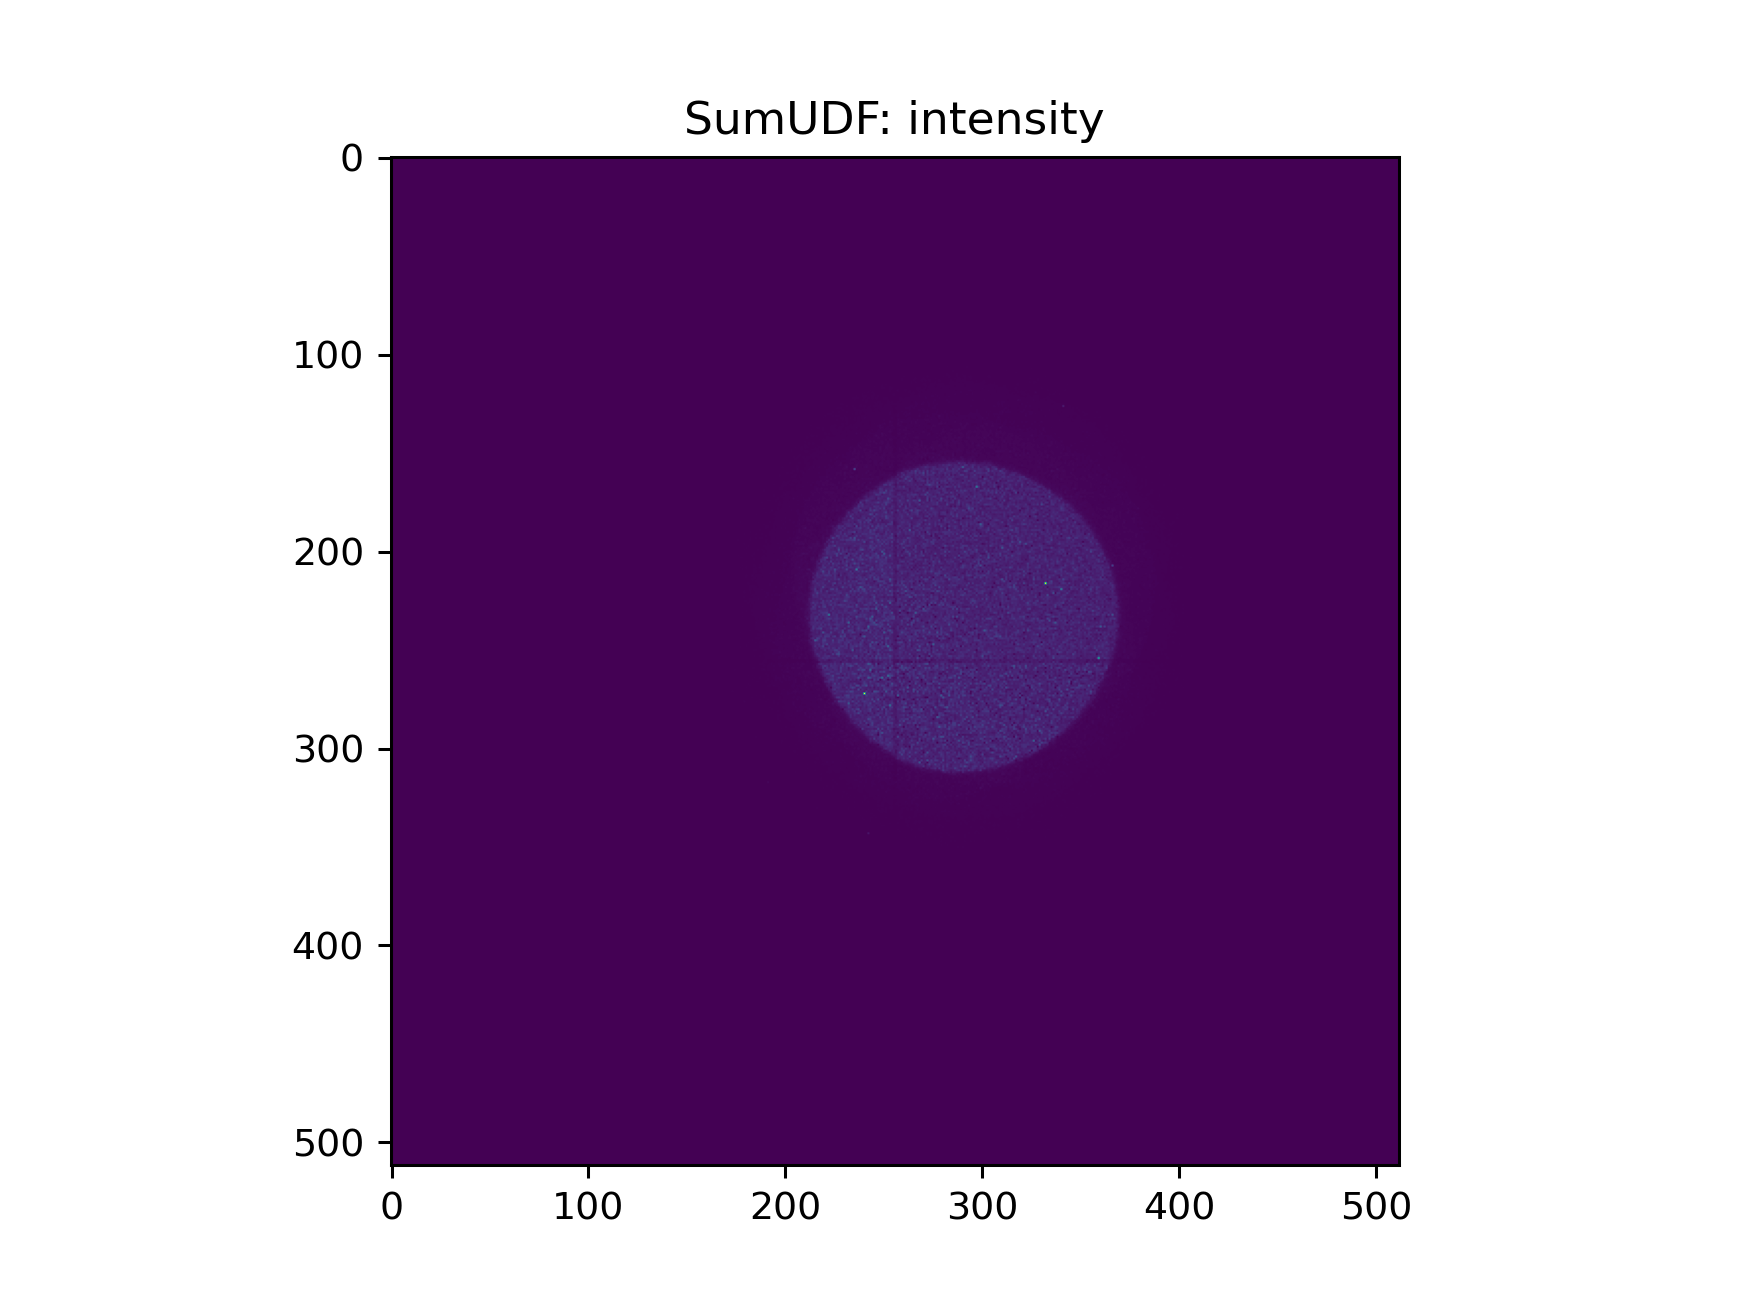

<IPython.core.display.Javascript object>


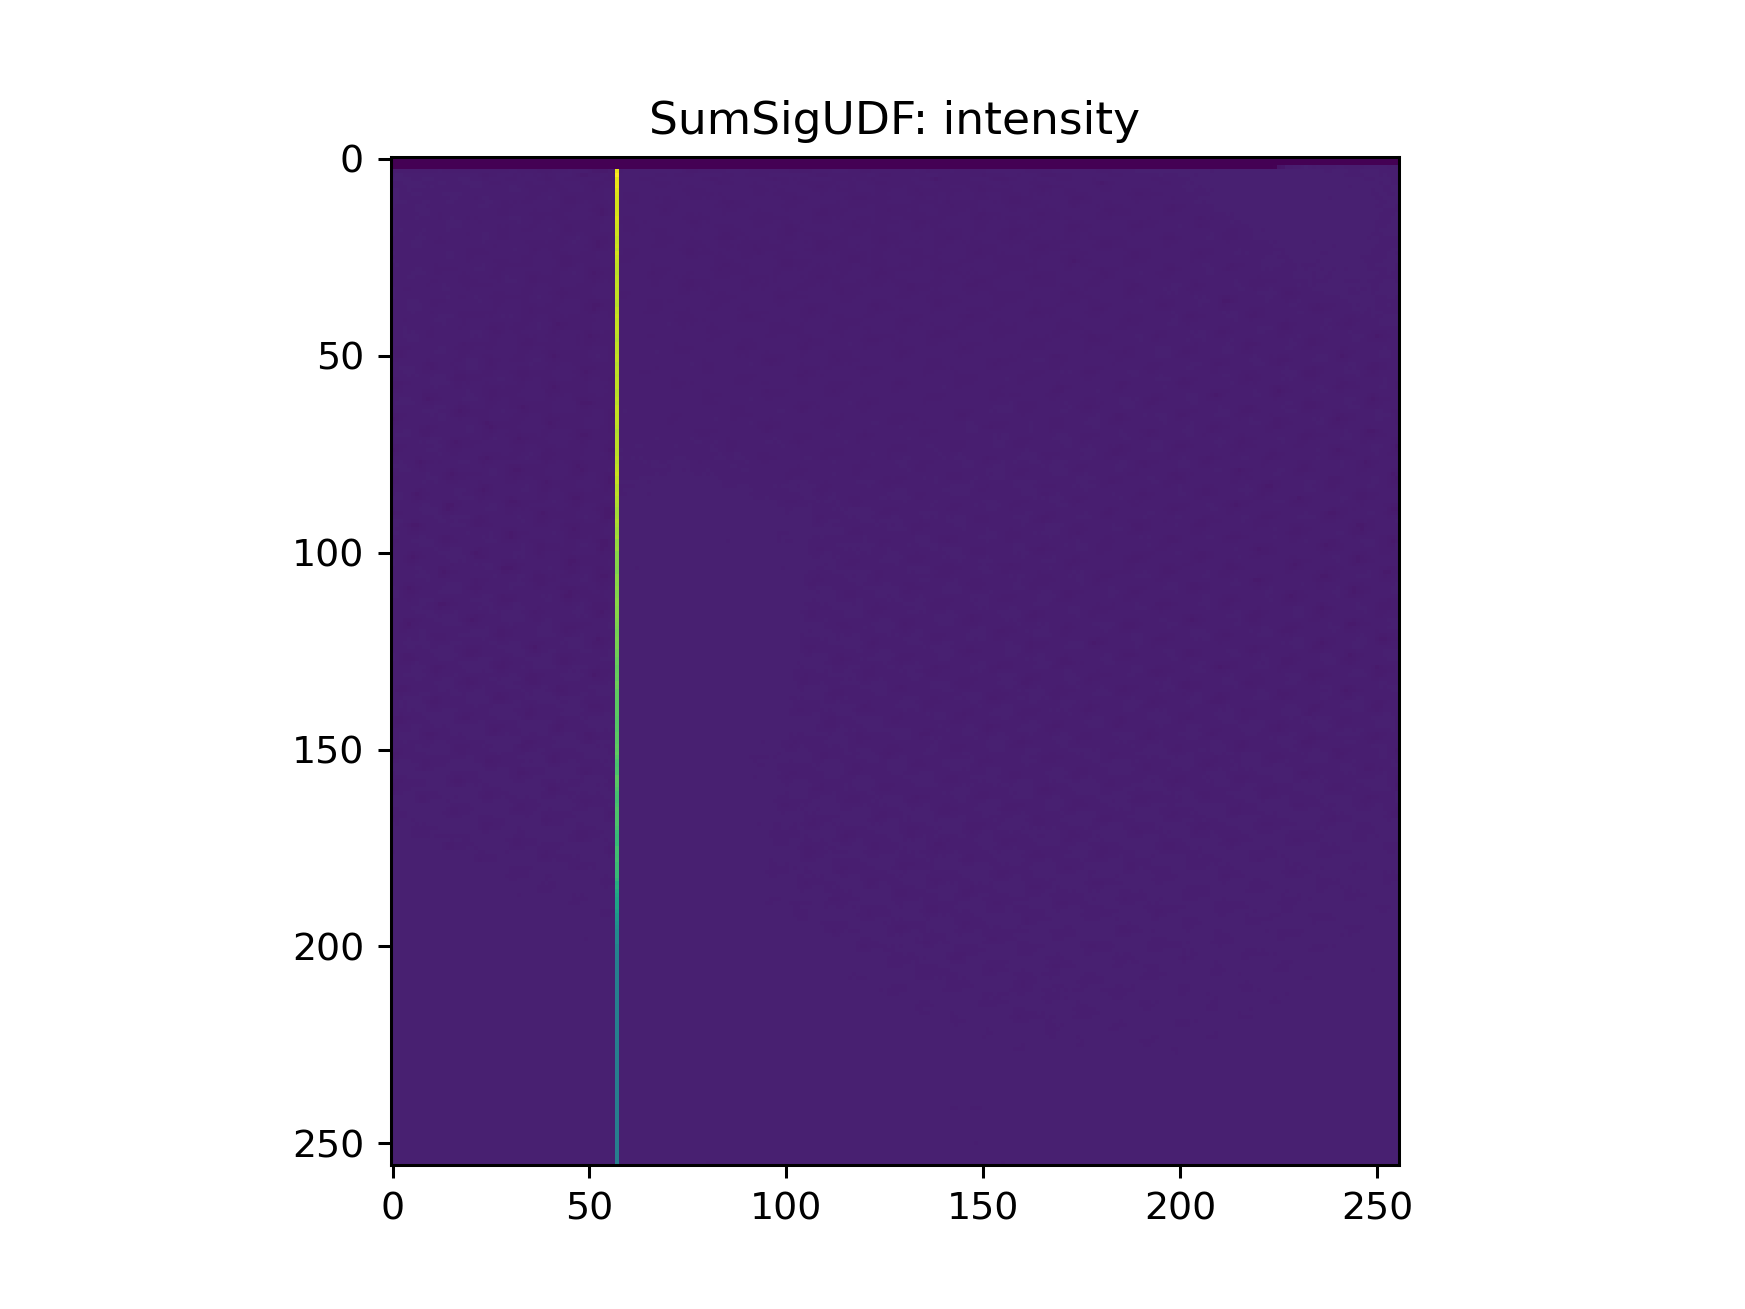

<IPython.core.display.Javascript object>


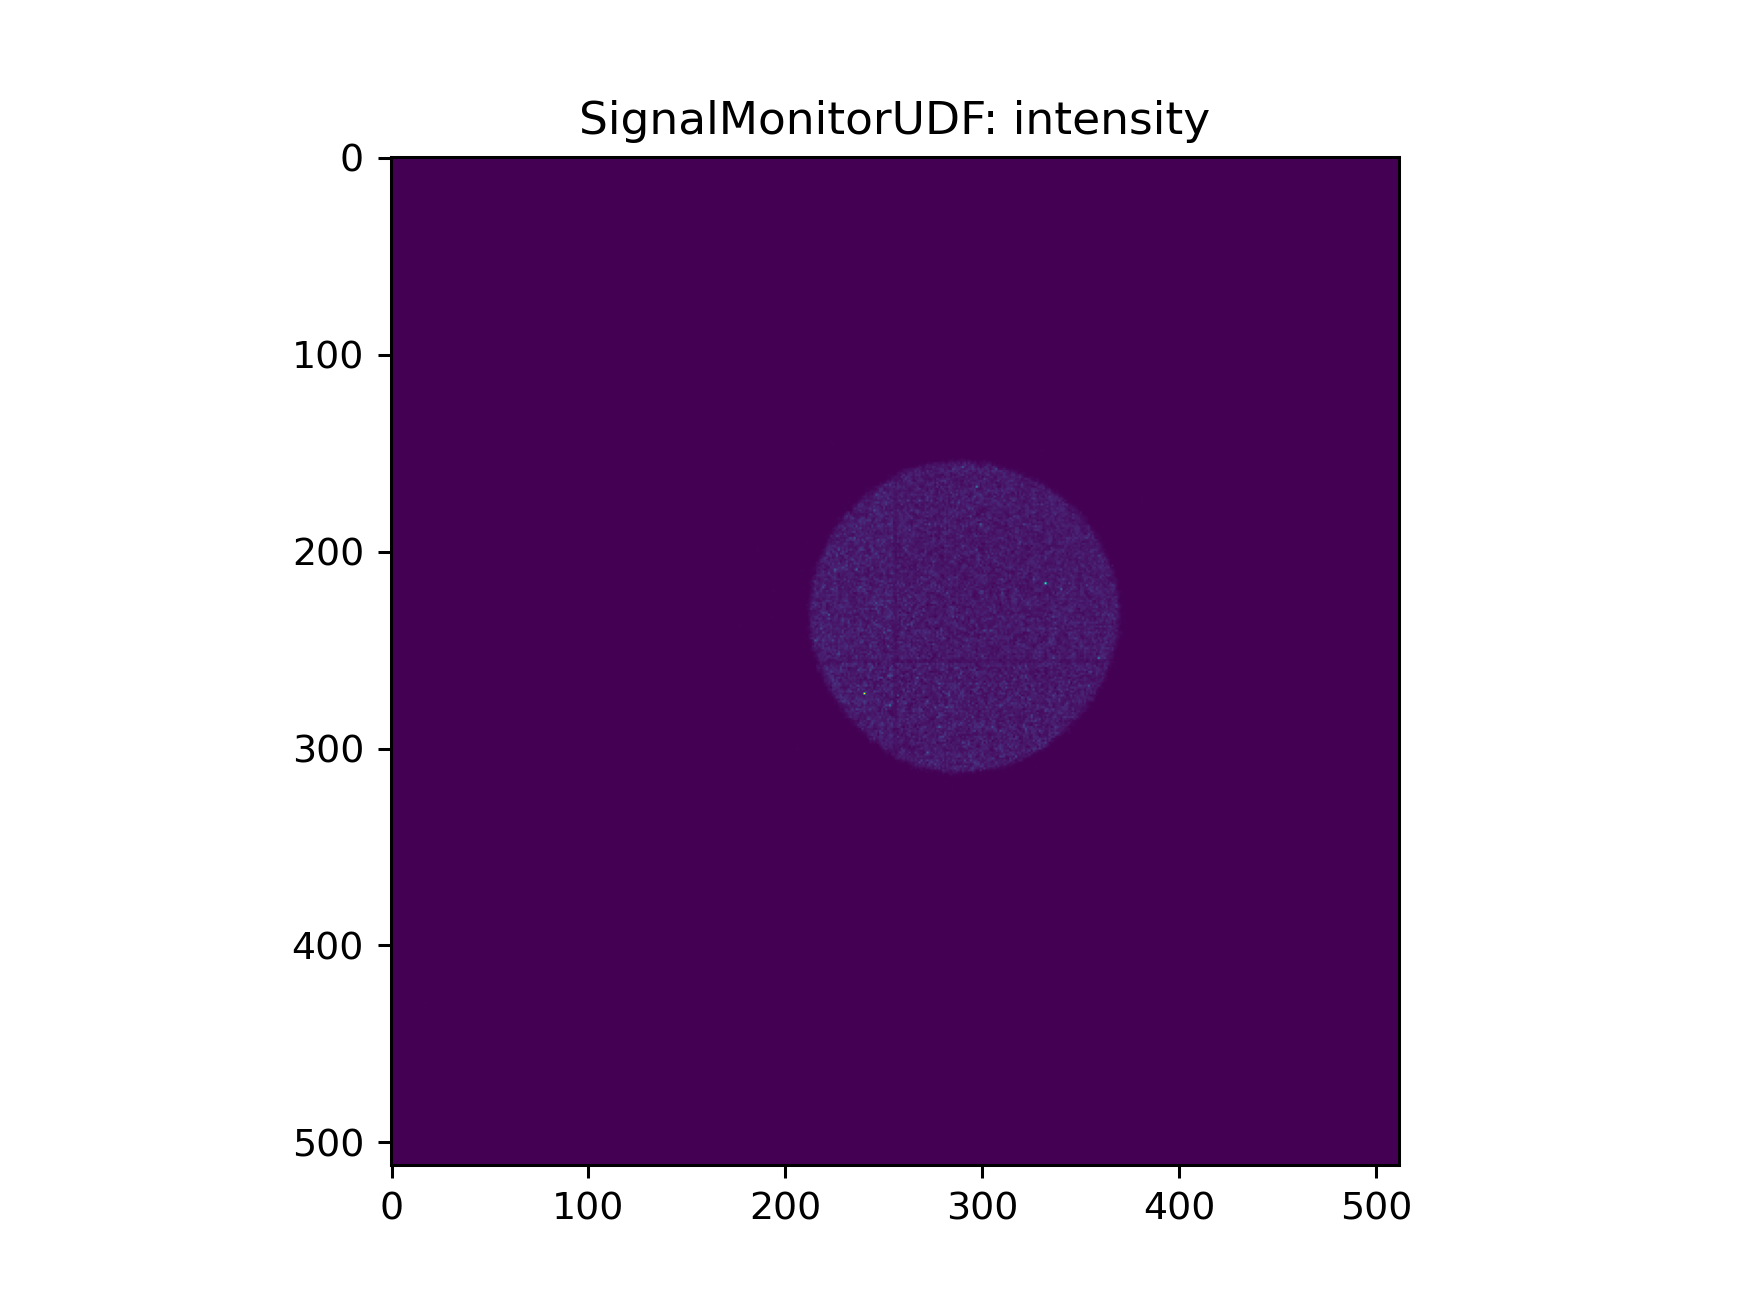

In [16]:
# NBVAL_IGNORE_OUTPUT
# (output is ignored in nbval run because it somehow doesn't play nice with bqplot)

outputs = []

for p in [p0, p1, p2]:
    p.display()

### Run one scan

The live plots above are updated with the results

In [18]:
%autoreload
c = MerlinControl(*MERLIN_CONTROL_SOCKET)

print("Connecting Merlin control...")
with c:
    merlin_setup(c)
    microscope_setup()

    set_nav(c, aq)
    arm(c)
try:
    ctx.run_udf(dataset=aq, udf=udfs, plots=[p0, p1, p2])
finally:
    try:
        if acquisition_state.trigger_result is not None:
            print("Waiting for blocking scan function...")
            print(f"result = {acquisition_state.trigger_result.result()}")
    finally:
        # Real world:
        # microscope.stop_scanning()
        pass
print("Finished.")

Connecting Merlin control...
Setting Merlin acquisition parameters
Finished Merlin setup.
Setting resolution...
Arming Merlin...
Merlin ready for trigger.
Triggering!


INFO:libertem_live.detectors.merlin.data:got headers; frame offset = 0


do_scan()
Waiting for blocking scan function...
result = None
Finished.
